# Train a Denoising Diffusion Probabilistic Model from scratch

Welcome! In this exercise you will train a DDPM from scratch. After training the model will be able to generate images of cars.

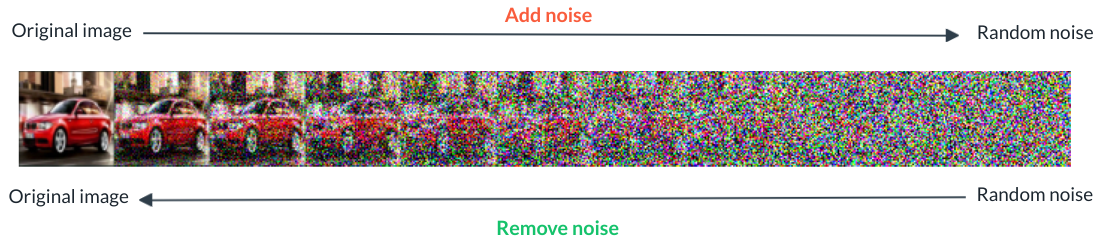

Let's get started!

## Initial setup

Here we import a few modules and we set up the notebook so it is fully reproducible:

In [1]:
# Make results fully reproducible:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
import numpy as np

seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Import a few things we will need
import torch.nn.functional as F
import torch
from torch.optim import Adam, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import multiprocessing

from torchvision import transforms 
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Dataset

Let's start by loading our training dataset. We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16,185 images. For this exercise we do not need any label, and we also do not need a test dataset, so we are going to load both the training and the test dataset and concatenate them. We are also going to transform the images to 64x64 so the exercise can complete more quickly:

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 100

def get_dataset(path):
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # We flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scales data into [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    train = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform, split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

data = get_dataset("/data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=multiprocessing.cpu_count(),
    persistent_workers=True
)

Let's look at a batch of images:

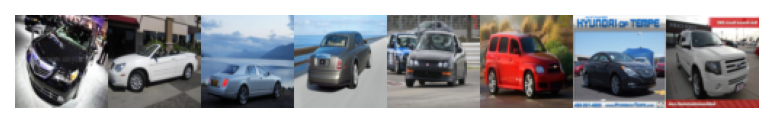

In [3]:
# Get a batch
batch, _ = next(iter(dataloader))

# Display it
def display_sequence(imgs, dpi=75, nrow=8):
    
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

_ = display_sequence(batch[:8], dpi=150)

## Noise scheduling and precomputation

In the forward process we need to add random noise according to a schedule. Here we use a linear schedule with 512 diffusion steps.

Let's define it:

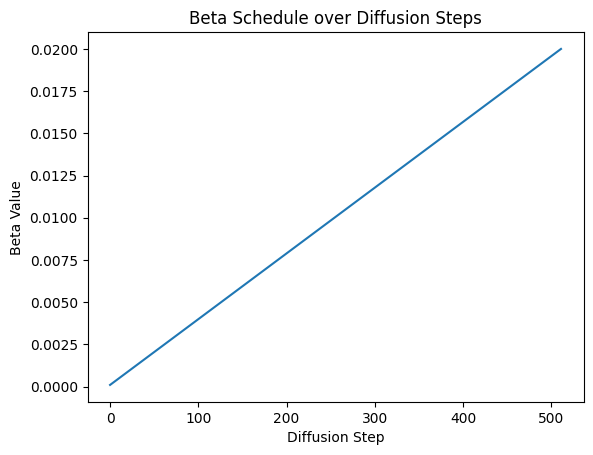

In [4]:
# Define beta schedule
T = 512  # number of diffusion steps
# YOUR CODE HERE
betas = torch.linspace(start=0.0001, end=0.02, steps=T)  # linear schedule

plt.plot(range(T), betas.numpy(), label='Beta Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Beta Value')
_ = plt.title('Beta Schedule over Diffusion Steps')

As we have seen in the lesson, we need to use a re-parametrization of the forward process that allows us to generate noisy images at any step without having to sequentially go through all the previous steps:

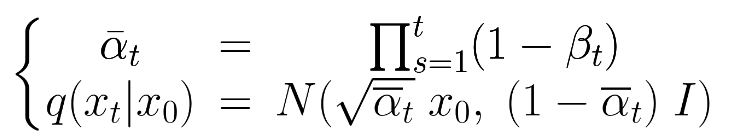

At inference time we will also need the quantities involved in these other formulas:

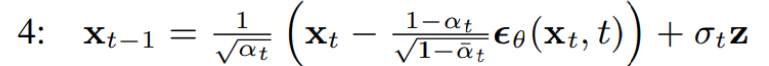
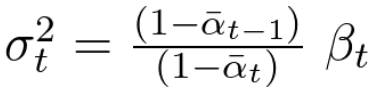

Here we define and precompute all these constants:

In [5]:
# Pre-calculate different terms for closed form
alphas = 1. - betas
# alpha bar
alphas_cumprod = torch.cumprod(alphas, axis=0)
# alpha bar at t-1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# sqrt of alpha bar
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

# Inference:
# 1 / sqrt(alpha)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
# sqrt of one minus alpha bar
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# sigma_t
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Here we define two utility functions, one to visualize the forward diffusion process, and the other one to make an inference call on an existing DDPM:

> **Fill the sections marked with YOUR CODE HERE**

In [6]:
@torch.no_grad()
def forward_diffusion_viz(image, device='cpu', num_images=16, dpi=75, interleave=False):
    """
    Generate the forward sequence of noisy images taking the input image to pure noise
    """
    # Visualize only num_images diffusion steps, instead of all of them
    stepsize = int(T/num_images)
    
    imgs = []
    noises = []
    
    for i in range(0, T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)

        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=device)
        img = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * image + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )

        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        noises.append(torch.clamp(noise, -1, 1).squeeze(dim=0))
    
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]


@torch.no_grad()
def make_inference(input_noise, return_all=False):
    """
    Implements the sampling algorithm from the DDPM paper
    """
    
    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    # YOUR CODE HERE
    for time_step in range(0, T)[::-1]:
        
        noise = torch.randn_like(x) if time_step > 0 else 0
        
        t = torch.full((bs,), time_step, device=device, dtype=torch.long)
        
        # YOUR CODE HERE
        x = sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1)
        ) + torch.sqrt(posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1]
    
    return x

### Forward process

Let's now simulate our forward process. If everything went well, you should see a few images like this one:

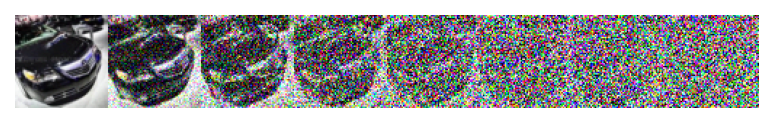

which show a few of the diffusion steps, from the original image to the left all the way to pure noise to the right.

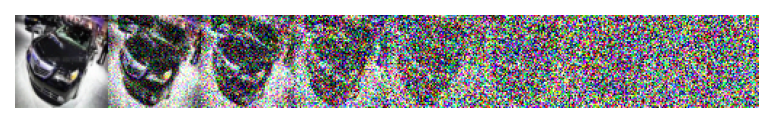

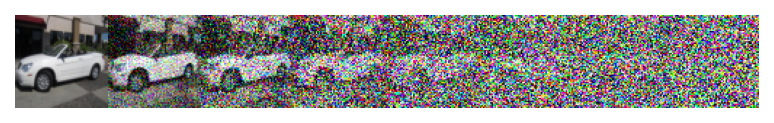

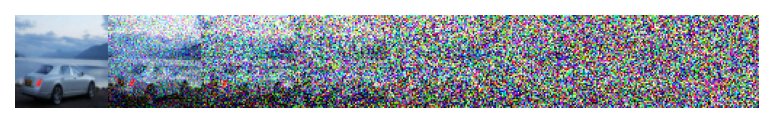

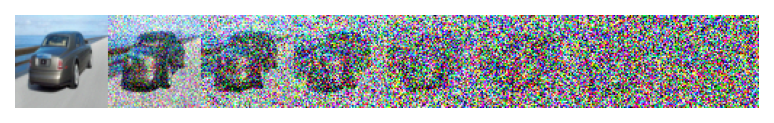

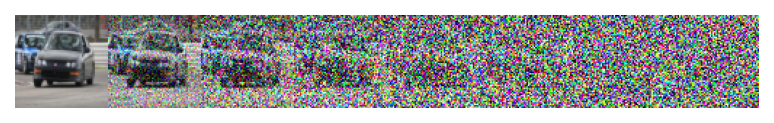

In [7]:
for image in batch[:5]:
    _ = forward_diffusion_viz(image.unsqueeze(dim=0), num_images=7, dpi=150, interleave=False)

## Training

### Model definition

Here we define the model we are going to train. We import a simple UNet model from the ``unet.py`` file (you can look into it if you like, but it is not required):

In [8]:
from unet import UNet

model = UNet(ch_mults = (1, 2, 1, 1))

# Uncomment this
# if you want to do the _VERY_ long training,
# model = UNet(ch_mults = (1, 2, 2, 2))

n_params = sum(p.numel() for p in model.parameters())
print(
    f"Number of parameters: {n_params:,}"
)

Number of parameters: 9,139,651


Our model has around 9.1 Million parameters. When compared to Stable Diffusion, which has 1 Billion parameters, it is very small! However, for this dataset, it can still give remarkable results.

### Training loop

Let's now do some preparation for the training loop. First we transfer the model as well as all our precomputed quantities to the GPU, so they can be used efficiently during training:

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Move everything to GPU
model.to(device)

sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
posterior_variance = posterior_variance.to(device)
betas = betas.to(device)

Now we can define the loss we are going to minimize:

> **Complete the section marked with YOUR CODE HERE**

In [10]:
# YOUR CODE HERE
criterion = torch.nn.MSELoss()

Then we define a few parameters for our training. We are going to use Cosine Annealing for the learning rate, with a warmup period. This means that we are going to start from a very low learning rate, increase it linearly for a few epochs, then start decreasing it again with a cosine shape:

In [11]:
base_lr = 0.0006 # Maximum learning rate we will use
epochs = 10 # Total number of epochs
T_max = epochs  # Number of epochs for Cosine Annealing. We do only one cycle
warmup_epochs = 2  # Number of warm-up epochs

# Uncomment the following lines
# if you want to do the _VERY_ long training,
# base_lr = 0.0001 # Maximum learning rate we will use
# epochs = 300 # Total number of epochs
# T_max = epochs  # Number of epochs for Cosine Annealing. We do only one cycle
# warmup_epochs = 10  # Number of warm-up epochs


optimizer = Adam(model.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=T_max - warmup_epochs,
    eta_min=base_lr / 10  # starting value for the LR
)

Finally let's train! We train only for 5 epochs, which should mean around 20 min of training time. This won't get us to a good result, but you will see a few hints of cars appearing little by little.

> **Complete the section marked with YOUR CODE HERE**

100%|██████████| 162/162 [02:51<00:00,  1.06s/it]


epoch 1: loss: 0.079, lr: 0.000300


100%|██████████| 162/162 [02:45<00:00,  1.02s/it]


epoch 2: loss: 0.056, lr: 0.000600


100%|██████████| 162/162 [02:45<00:00,  1.02s/it]


epoch 3: loss: 0.049, lr: 0.000579


100%|██████████| 162/162 [02:46<00:00,  1.03s/it]


epoch 4: loss: 0.043, lr: 0.000521


100%|██████████| 162/162 [02:46<00:00,  1.03s/it]


epoch 5: loss: 0.043, lr: 0.000433


100%|██████████| 162/162 [02:45<00:00,  1.02s/it]


epoch 6: loss: 0.039, lr: 0.000330


100%|██████████| 162/162 [02:44<00:00,  1.01s/it]


epoch 7: loss: 0.042, lr: 0.000227


100%|██████████| 162/162 [02:44<00:00,  1.02s/it]


epoch 8: loss: 0.038, lr: 0.000139


100%|██████████| 162/162 [02:45<00:00,  1.02s/it]


epoch 9: loss: 0.038, lr: 0.000081


100%|██████████| 162/162 [02:46<00:00,  1.03s/it]


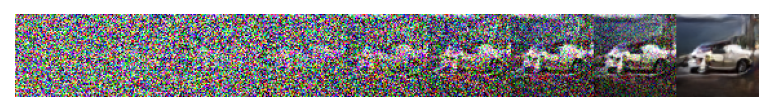

epoch 10: loss: 0.039, lr: 0.000060


In [12]:
# We will use this noise to generate some images during training to check
# where we stand
fixed_noise = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

alpha = 0.1  # Smoothing factor
ema_loss = None  # Initialize EMA loss

for epoch in range(epochs):
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        # Cosine Annealing after warm-up
        scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
        
    for batch, _ in tqdm(dataloader):
        
        batch = batch.to(device)
        bs = batch.shape[0]
        
        optimizer.zero_grad()
        
        # YOUR CODE HERE
        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        
        # Generate targets for the UNet and apply them to the images
        noise = torch.randn_like(batch, device=device)
        x_noisy = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * batch + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )
        
        noise_pred = model(x_noisy, t)
        loss = criterion(noise, noise_pred)
        
        loss.backward()
        optimizer.step()
        
        if ema_loss is None:
            # First batch
            ema_loss = loss.item()
        else:
            # Exponential moving average of the loss
            ema_loss = alpha * loss.item() + (1 - alpha) * ema_loss
    
    if epoch == epochs-1:
        with torch.no_grad():
    #         fig, _ = sample_image(fixed_noise, forward=False, device=device)
            imgs = make_inference(fixed_noise, return_all=True)
            fig = display_sequence([imgs[0].squeeze(dim=0)] + [x.squeeze(dim=0) for x in imgs[63::64]], nrow=9, dpi=150)
            plt.show(fig)
        os.makedirs("diffusion_output_long", exist_ok=True)
        fig.savefig(f"diffusion_output_long/frame_{epoch:05d}.png")
    #plt.close(fig)
    
    print(f"epoch {epoch+1}: loss: {ema_loss:.3f}, lr: {current_lr:.6f}")

## Inference

We can now have a look at what our model can produce:

> **Complete the section marked with YOUR CODE HERE**

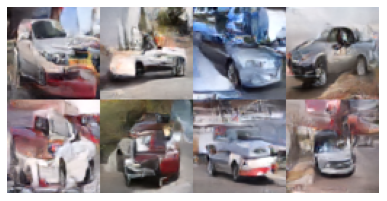

In [13]:
# YOUR CODE HERE
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=device)
imgs = make_inference(input_noise)
_ = display_sequence(imgs, dpi=75, nrow=4)

This is a fairly good result considering how small the model is and how little we trained it. We can already tell that it is indeed creating cars, with windshields and wheels, although it is still very early on. If we were to train for much longer, and/or use a larger model (for example, the one defined above in the commented lines has 55 Million parameters) and let it train for several hours, we would get something even better, like this:

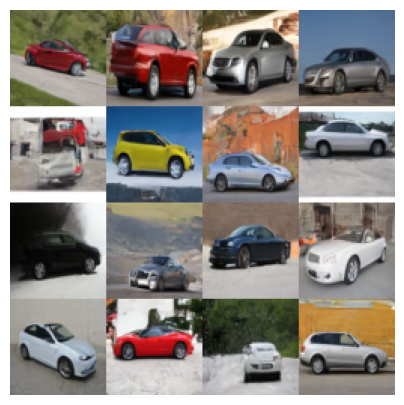

If you want, you can see for yourself by uncommenting the lines in the code above, but make sure you come back to the running notebook at least once every 30 min and so something like scrolling and clicking, otherwise Udacity will kill your notebook and you'll have to start over.